In [11]:
# reset notebook
%reset -f

In [12]:
# Import packages
import os
import shutil
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt

In [5]:
def scale_phonon_dos(path, num_atoms, plot=False):

    # Keep track of the original path
    original_path = os.getcwd()

    # Collect all the vdos and volph files in the working path
    file_list = os.listdir(path)
    os.chdir(path)

    volph_files = [file for file in file_list if 'volph' in file]
    vdos_files = [file for file in file_list if 'vdos' in file]

    # Create a folder to save the scaled phonon DOS in the parent directory. If it already exists, delete it and create a new one.
    working_path = os.getcwd()
    os.chdir('..')
    dir_to_create = 'scaled_phonon_dos'

    if os.path.exists(dir_to_create):
        shutil.rmtree(dir_to_create)
    os.makedirs(dir_to_create)
    os.chdir(working_path)

    # The area under the curve of the phonon DOS is normalized to ~ 3N in YPHON. We will scale our phonon DOS to 3N for the number of atoms, N, specified.
    num_atoms_3N = num_atoms * 3

    # Loop over the phonon dos from the vdos files and scale them one-by-one
    i = 0
    for file in vdos_files:
        data = np.loadtxt(file)

        # Remove the negative frequencies
        data_new = data[data[:, 0] > 0]

        # Insert a zero frequency and zero DOS at the beginning of the array
        data_new = np.insert(data_new, 0, [0, 0], axis=0)

        # Calculate the area under the curve of the phonon DOS
        area = np.trapz(data_new[:, 1], data_new[:, 0])

        # Scale the area under the curve of the phonon DOS to 3N
        data_new[:, 1] = data_new[:, 1] * num_atoms_3N / area

        # Calculate the new area under the curve of the scaled phonon DOS
        area = np.trapz(data_new[:, 1], data_new[:, 0])

        # Save the scaled phonon DOS to the scaled_phonon_dos folder
        np.savetxt(os.path.join('../scaled_phonon_dos', file), data_new)

        # Plot the original and scaled phonon DOS on the same plot for comparison
        if plot == True:
            plt.plot(data[:, 0], data[:, 1], label='original')
            plt.plot(data_new[:, 0], data_new[:, 1], label='scaled')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('DOS (1/Hz)')
            plt.legend()
            title = np.loadtxt(volph_files[i])
            title = 'Volume = ' + str(round(title.item(), 2)) + ' ' + 'Å³/atom'
            plt.title(title)
            plt.show()

        i += 1

    # Copy all files that start with volph to the scaled_phonon_dos folder
    for file in volph_files:
        shutil.copy(file, '../scaled_phonon_dos')

    # Return to original path
    os.chdir(original_path)

In [21]:
scale_phonon_dos('180DW/with_dipole/original', 5)

In [70]:
# TODO: Integrate this with eos_fit.py
import numpy as np


def eosfitall(volume, energy, m, n):

    volume_range = np.linspace(np.min(volume), np.max(volume), 1000)
    volume_range = volume_range[:, np.newaxis]

    if m == 1:  # mBM
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), volume**(-1 / 3)))
            A2 = np.hstack(
                (np.ones(volume_range.shape), volume_range**(-1 / 3)))
        elif n == 3:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-1 / 3), volume**(-2 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape),
                           volume_range**(-1 / 3), volume_range**(-2 / 3)))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-1 / 3), volume**(-2 / 3), volume**(-1)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range **
                           (-1 / 3), volume_range**(-2 / 3), volume_range**(-1)))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), volume**(-1 / 3),
                           volume**(-2 / 3), volume**(-1), volume**(-4 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range**(-1 / 3),
                           volume_range**(-2 / 3), volume_range**(-1), volume_range**(-4 / 3)))

    elif m == 2:  # BM
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), volume**(-2 / 3)))
            A2 = np.hstack(
                (np.ones(volume_range.shape), volume_range**(-2 / 3)))
        elif n == 3:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-2 / 3), volume**(-4 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape),
                           volume_range**(-2 / 3), volume_range**(-4 / 3)))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-2 / 3), volume**(-4 / 3), volume**(-2)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range **
                           (-2 / 3), volume_range**(-4 / 3), volume_range**(-2)))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), volume**(-2 / 3),
                           volume**(-4 / 3), volume**(-2), volume**(-8 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range**(-2 / 3),
                           volume_range**(-4 / 3), volume_range**(-2), volume_range**(-8 / 3)))

    elif m == 3:  # LOG
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), np.log(volume)))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(volume_range)))
        elif n == 3:
            A1 = np.hstack(
                (np.ones(volume.shape), np.log(volume), np.log(volume)**2))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(
                volume_range), np.log(volume_range)**2))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), np.log(
                volume), np.log(volume)**2, np.log(volume)**3))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(
                volume_range), np.log(volume_range)**2, np.log(volume_range)**3))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), np.log(volume), np.log(
                volume)**2, np.log(volume)**3, np.log(volume)**4))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(volume_range), np.log(
                volume_range)**2, np.log(volume_range)**3, np.log(volume_range)**4))

    eos_parameters = np.linalg.pinv(A1).dot(energy)
    energy_fit = np.dot(A2, eos_parameters)

    return eos_parameters.T, energy_fit.T

In [95]:
def harmonic(path, T_range, num_atoms, eos_type, eos_rank):
    
    # Temperature range
    T = np.arange(T_range[0], T_range[1] + T_range[2], T_range[2])
    num_T = len(T)
    
    # Read the volumes
    file_list = os.listdir(path)
    volph_files = [file for file in file_list if 'volph' in file]
    for file in volph_files:
        volume = np.loadtxt(path + '/' + file)
        volume = volume.item()
        if 'volumes' in locals():
            volumes = np.append(volumes, volume)
        else:
            volumes = np.array([volume])
    
    # Constants
    k_B = scipy.constants.Boltzmann / scipy.constants.electron_volt  # The Boltzmann constant in eV/K
    h = scipy.constants.Planck / scipy.constants.electron_volt  # The Planck's constant in eVs
    
    # Read the scaled phonon DOS files from path
    vdos_files = [file for file in file_list if 'vdos' in file]
    for file in vdos_files:
        phonon_dos = np.loadtxt(path + '/' + file)
        
        # Extract frequency and dos from the scaled phonon DOS files
        frequency = phonon_dos[:, 0]  # Hz
        dos = phonon_dos[:, 1]  # 1/Hz
        
        # df, mid_f, and mid_dos are used to evaluate the integrals
        df = frequency[1:] - frequency[:-1]
        mid_f = (frequency[1:] + frequency[:-1]) * 0.5  # Use the middle value for the frequency in the integral
        mid_dos = (dos[1:] + dos[:-1]) * 0.5  # Use the middle value for the DOS in the integral
        
        # If abs(mid_f) < 1e-39, set it to 1e-39
        # TODO: review if this is necessary
        mid_f[np.abs(mid_f) < 1e-39] = 1e-39
        
        harmonic_properties = []
        # Calculate the harmonic properties for each volume of the phonon DOS over the temperature range
        for i in np.arange(T_range[0], T_range[1] + T_range[2], T_range[2]):
            constant = (h * mid_f) / (2 * k_B * i)

            A = df * mid_dos * np.log(2 * np.sinh(constant))
            free_energy = k_B * i * np.sum(A)  # eV/num_atoms

            A = df * mid_dos * (h * mid_f) * np.cosh(constant) / np.sinh(constant)
            internal_energy = 0.5 * np.sum(A)  # eV/num_atoms

            A = constant * np.cosh(constant) / np.sinh(constant) - np.log(2 * np.sinh(constant))
            entropy = k_B * np.sum(df * mid_dos * A)  # eV/K/num_atoms

            A = (1 / np.sinh(constant))**2
            cv = k_B * np.sum(df * mid_dos * constant**2 * A)  # eV/K/num_atoms

            harmonic_properties.append([i, free_energy, internal_energy, entropy, cv])
        
        # Convert list to numpy array
        harmonic_properties = np.vstack(harmonic_properties)
        
        # Collect the harmonic properties in a numpy array
        if 'free_energy_all' in locals():
            free_energy_all = np.hstack((free_energy_all, (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]))
        else:
            free_energy_all = (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]  # eV/atom
        
        if 'entropy_all' in locals():
            entropy_all = np.hstack((entropy_all, (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]))
        else:
            entropy_all = (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]  # eV/K/atom
            
        if 'cv_all' in locals():
            cv_all = np.hstack((cv_all, (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]))
        else:
            cv_all = (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]  # eV/K/atom
    
    # Fit the harmonic properties to an equation of state
    for i in range(num_T):
        free_energy_fit_append, y1_append = eosfitall(volumes[:, np.newaxis], free_energy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        #print(y1_append)
        if i == 0:
            free_energy_fit = free_energy_fit_append
            y1 = y1_append
        else:
            free_energy_fit = np.vstack((free_energy_fit, free_energy_fit_append))
            y1 = np.vstack((y1, y1_append))

        entropy_fit_append, y2_append = eosfitall(volumes[:, np.newaxis], entropy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            entropy_fit = entropy_fit_append
            y2 = y2_append
        else:
            entropy_fit = np.vstack((entropy_fit, entropy_fit_append))
            y2 = np.vstack((y2, y2_append))
            
        cv_append, y3_append = eosfitall(volumes[:, np.newaxis], cv_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            cv_fit = cv_append
            y3 = y3_append
        else:
            cv_fit = np.vstack((cv_fit, cv_append))
            y3 = np.vstack((y3, y3_append))
    
    volume_range = np.linspace(np.min(volumes), np.max(volumes), 1000)
            
    return T, free_energy_all, entropy_all, cv_all, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range
    # -> volume, down -> temperature
    # Each row is at a constant T
    # Each column is at a constant volume

In [96]:
# Gives the same answer as the MATLAB code
#free_energy_all, entropy_all, cv_all, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3
[T, free_energy, entropy, cv, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range] = harmonic('MATLAB_FEG_with_dipole', [10, 1000, 10], 5, 2, 2)

(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 1000)
(1, 2) (1, 100

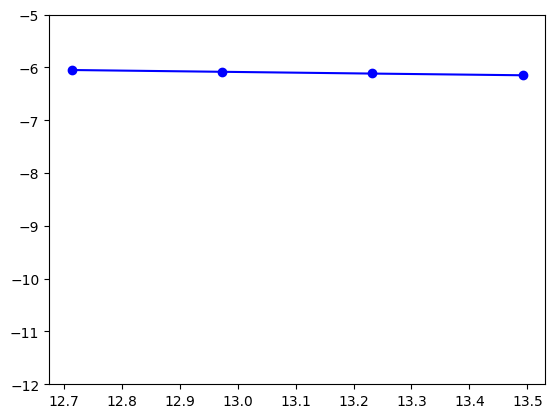

In [106]:

plt.plot(volumes, free_energy[69, :]*50, 'bo')
plt.ylim(-12, -5)
plt.plot(volume_range, y1[69, :]*50, 'b')
#print(volume_range)
#print(y1[0, :])

In [14]:
# Previous results
print(y_all)

[[ 0.05855354  0.05853555  0.05845833 ... -0.25757023 -0.26286026
  -0.26817578]
 [ 0.05855351  0.05853551  0.0584583  ... -0.25757322 -0.26286328
  -0.26817884]
 [ 0.05855348  0.05853548  0.05845826 ... -0.25757622 -0.26286631
  -0.26818189]
 ...
 [ 0.05852341  0.05850366  0.05842305 ... -0.26040822 -0.2657284
  -0.27107407]
 [ 0.05852338  0.05850363  0.05842302 ... -0.26041093 -0.26573114
  -0.27107684]
 [ 0.05852335  0.0585036   0.05842298 ... -0.26041364 -0.26573388
  -0.2710796 ]]


In [ ]:
# Clean up and document runelephonly!
# TODO: Clean up all of the variable names for harmonic